red is negative and blue is positive ( because I'm not at all biased :) .... sorry about the scrolling.

In [14]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from wordcloud import WordCloud

import nltk.data
from nltk.corpus import subjectivity, stopwords, wordnet, sentiwordnet
from nltk import word_tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
# set plot size
plt.rcParams['figure.figsize'] = (12.0, 10.0)

/usr/local/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


some globals for general analysis...

In [15]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

# a little memoization for synset word scores
WORD_SCORES = {}

# for replacing contractions post-tokenization
CONTRACTION_MAP = {"'s": "is",
                   "'ll": 'will',
                   "n't": "not",
                   "'ve": "have",
                   "'re": "are",
                   "'m": "am",
                   "ca": "can",
                   "'d": "would"}

# this maps nltk 'universal' tags to wordnet tags
POS_TAG_MAP = {'NOUN': 'n', 'ADJ': 'a', 'VERB': 'v', 'ADV': 'r'}

a couple little helper functions:

In [16]:
def normalize_arr(arr, mn= None, mx= None):
    if not mn:
        mn, mx = min(arr), max(arr)
    return list(map(lambda x : (x - mn)/ (mx - mn), arr))

def replace_contractions(token):
    if token in CONTRACTION_MAP:
        return CONTRACTION_MAP[token]
    return token

clean, breakdown text and do sentiment

first, I'm scoring using sentences first using [VADER](1)  then combining that with the individial word scores from senti_synsets ( I take the average of all synset matches based on word and POS) . Then I normalize took the mean positive and negative scores for each unique word *within one individual's vocabulary* at which point I throw out the POS, and finally I normalize the both the positive and negative scores ( again for the individual's vocabulary)


 

----------

   [1]: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [17]:
#break down lines into sentences & score sentences
def get_sentences(lines):
    """break down lines into sentences
    returns a list of [(sentence, polarity score)] 
    tuples
    """
    sentences = []
    for line in lines:
        these_sents = sentence_tokenizer.tokenize(line)
        for sent in these_sents:
            sentences.append((sent, sid.polarity_scores(sent)))
    return sentences
  
    
def word_senti_score(word, POS):
    """returns nltk sentiwordnet...
    Args:
        word (str): Description
        pos (str): part of speech should be 
                   gotta be in NLTK wordnet
    Returns:
        TYPE: pos & neg values... skips neu
    """
    p, n = 0., 0.
    try:
        p, n =  WORD_SCORES[(word, POS)]
    except KeyError:
        scores = list(sentiwordnet.senti_synsets(word, POS))
        if scores: # this will average all synset words for given POS
            p = sum([s.pos_score() for s in scores])/ len(scores)
            n = sum([s.neg_score() for s in scores])/len(scores)
        WORD_SCORES[(word, POS)] = (p, n)
    return p, n

# workhorse for breaking down sentences, pos_tagging, lemmatization, returns tagged
#lemmatized words with their initial scores
def get_words(sent, sent_score, word_clean, stopwords=[], exceptions=[]):
    """tag and tokenize sentance, do cleanup on words
        and return list of word, POS pairs with their synset
        scores combined with the score of their context sentence

    Args:
        sent (str): sentence, not tokenized
        sent_score (tuple) : pos and neg scores for sentence
        word_clean (function): cleaning function to be run on
                               words after tagging
        stopwords (List): list of stopwords
        exceptions (list, optional): these words will escape the
                                     lemmatizer.
    Returns:
        List of tuples: [(word, POS, positive score, negative score)]
    """
    tagged = pos_tag(word_tokenize(sent), tagset='universal')
    words = [(word_clean(x), y) for (x,y) in tagged]
    res = []
    s_pos, s_neg = sent_score
    for (w, t) in words:
        #basically throwing everything not in i'm ok with that since
        #i've already used full sentences for polarity scores
        if t in POS_TAG_MAP:
            POS = POS_TAG_MAP[t]
            if w in exceptions: # don't lemmatize words like 'ISIS'
                word, POS = w,POS
            else:
                 word = lemmatizer.lemmatize(w, POS)
            if word not in stopwords: 
                p, n = word_senti_score(word, POS)
                # this is a little arbitrary but it seems to work well...
                # I add the (often 0. in the case of neutral words) senti_synset
                # score to the vader score for that sentence....
                w_pos = 1. * (p + s_pos )
                w_neg = 1. * (n + s_neg)
                res.append((word, POS, w_pos, w_neg))
    return res
    

def get_vocab(sentences, word_getter):
    words = []
    for sentence, score in sentences:
        s_pos, s_neg = score['pos'] , score['neg']
        words += word_getter(sentence, (s_pos, s_neg))
    unique_words = set([e[0] for e in words])
    vocab = [list(unique_words), [], [], []] # word, count, pos, neg ... because pandas joins make everyting slower
    for u_word in unique_words:
        w_dat = [e for e in words if  e[0] == u_word]
        count = len(w_dat)
        vocab[1].append(count)
        # ... then i get the mean for all uses of that word (within a single individuals
        # vocabulary)
        p, n = sum([e[-2] for e in w_dat])/ float(count), sum([e[-1] for e in w_dat])/ float(count)
        vocab[2].append(p)
        vocab[3].append(n)
                        
    #then i scale scores for entire vocab between 0 & 1
    vocab[2] = normalize_arr(vocab[2])
    vocab[3] = normalize_arr(vocab[3])
    return vocab


def get_data(lines, additional_stopwords=[], exceptions=[]):
    sentences = get_sentences(lines)
    (words, counts, pos_vals, neg_vals) = get_vocab(sentences, 
                                                    word_getter= lambda s, sc: get_words(s, sc,
                                                                                   word_clean=lambda x: replace_contractions(x.lower()),
                                                                                    stopwords=additional_stopwords | STOP_WORDS,
                                                                                    exceptions=exceptions)                                                                             )
    return pd.DataFrame({'word': words, 
                    'count': counts, 
                     'pos': pos_vals, 
                     'neg': neg_vals}, 
                       columns = ['word', 'count', 'pos', 'neg'])


fun stuff. functions to generate clouds using  [amuller's super awesome wordcloud library](https://github.com/amueller/word_cloud).  The function `sent_color_function` uses the sentiment scores generated earlier and weights the red and blue values.

In [59]:
def gen_cloud(data):
    counts = [(w, data[w]['count']) for w in data]
    def sent_color_function(word=None, font_size=None, position=None,
                            orientation=None, font_path=None, random_state=None):
        """sentiment color generator for WordCloud 
        """
        r, g, b = 126 + int(255 * data[word]['neg']), 126, 126 + int(255 * data[word]['pos'])
        if r > 255:
            v = r - 255
            b = max(b - v, 0)
            g = max(g - v, 0)
            r = 255
        if b > 255:
            v = b - 255
            r = max(r - v, 0)
            g = max(g - v, 0) 
            b = 255
        return "rgb({}, {}, {})".format(r, g, b)

    wordcloud = WordCloud(  max_font_size = 100,
                            width= 800, 
                            height = 400,
                            color_func=sent_color_function).generate_from_frequencies(counts)
    return wordcloud


def show_cloud(cloud, label):
    plt.title(label)
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()
    
def show_basics(vocab):
    print('unique word count : {}\n'.format(vocab.shape[0]))
    print( 'top 10 most used frequent words:')
    print( vocab.nlargest(10, 'count'), '\n')
    print( 'most positive words:')
    print( vocab.nlargest(10, 'pos'), '\n')
    print( 'most negative words:')
    print( vocab.nlargest(10, 'neg'), '\n')
    

**junk**  is some common words that will be added to stopwords, obviously both candidates had said  'president' and 'country' and 'people' with high frequency... which is pretty meaningless as they are both running to be *president* of a  *country* full of *people*. Other highlights include *Lester* Holt,  who Clinton and Trump called by his first name 6 and 7 times respectively. 

**exceptions** is a list of words that will escape the lemmatizer... otherwise *isis* becomes *isi*...
 

In [60]:
junk = set([ 'say', 'get', 'think', 'go', 'people', 'well', 'come', 'would', 'could',
             'would', 'want', 'become', 'donald', 'hillary', 'lester', 'make', 'chris', 'know', 
             'take', 'lot', 'tell', 'way', 'need', 'give', 'see', 'year', 'many', 'talk', 'clinton', 
             'trump', 'really', 'look', 'let', 'much', 'thing', 'country', 'president', 'also'])

exceptions = ['isis', 'isil', 'sanders']

In [61]:
# read in data
df = pd.read_csv('debate.csv', encoding= "latin1")

lets just deal with Clinton/ Trump for now...  

In [62]:

#get vocab as pandas for canidates
clinton_vocab = get_data(  list(df['Text'][df['Speaker'] == 'Clinton'].values), 
                                additional_stopwords=junk, 
                                exceptions=exceptions)

trump_vocab = get_data( list(df['Text'][df['Speaker'] == 'Trump'].values), 
                           additional_stopwords=junk, 
                           exceptions=exceptions)

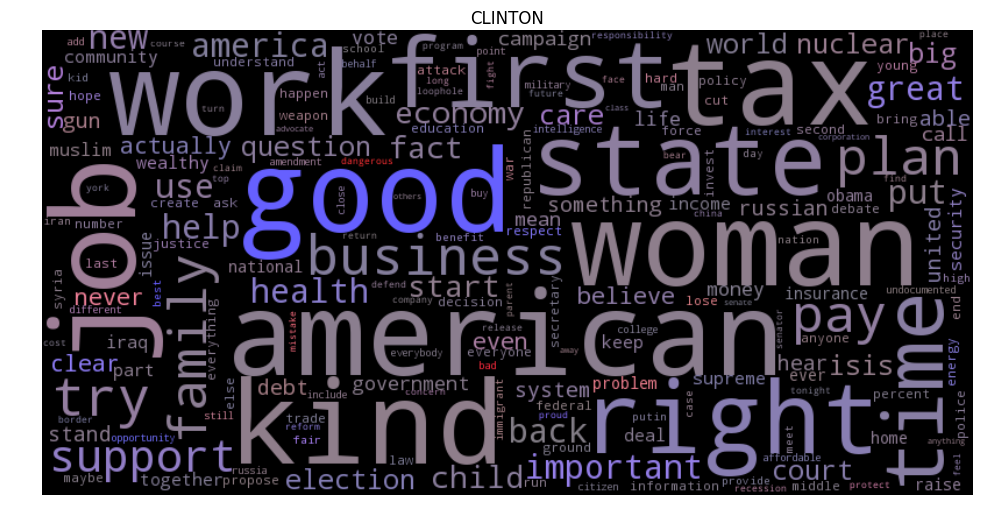

In [63]:
# build clinton's cloud
clinton_cloud = gen_cloud(dict(clinton_vocab.set_index('word').to_dict('index')))
show_cloud(clinton_cloud, label = 'CLINTON')

In [64]:
#show some basic data
show_basics(clinton_vocab)

unique word count : 1766

top 10 most used frequent words:
          word  count       pos       neg
1503      work     83  0.115462  0.040211
1152     woman     50  0.058035  0.065082
31    american     49  0.069874  0.052511
601        job     48  0.101618  0.128550
1603       tax     48  0.055803  0.058417
1569      good     41  0.626692  0.025164
802       kind     37  0.052270  0.068486
1735     right     36  0.206749  0.041641
430      state     35  0.132247  0.059944
967      first     34  0.115949  0.040674 

most positive words:
            word  count       pos       neg
1445   beautiful      1  1.000000  0.000000
727    excellent      1  0.957360  0.000000
408     wellness      1  0.849833  0.000000
1226        love      2  0.839451  0.024894
766      awesome      3  0.800643  0.116038
849    fortunate      4  0.777098  0.000000
1009   wonderful      2  0.760845  0.000000
1153  optimistic      1  0.754171  0.149363
300     thorough      1  0.720430  0.000000
880       admire

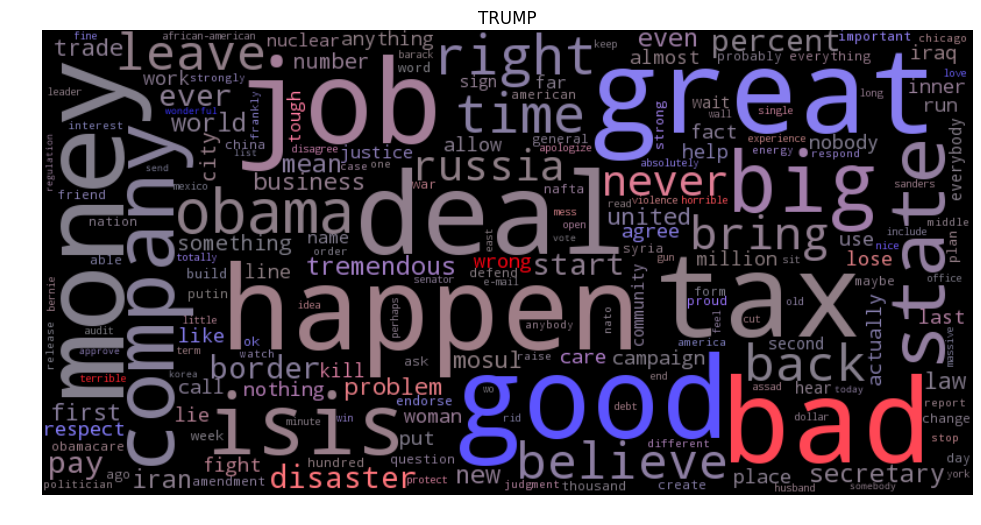

In [65]:
# ditto trump...
trump_cloud = gen_cloud(dict(trump_vocab.set_index('word').to_dict('index')))
show_cloud(trump_cloud, label = 'TRUMP')


In [66]:
#show some basic data
show_basics(trump_vocab)

unique word count : 1429

top 10 most used frequent words:
         word  count       pos       neg
268       bad     69  0.056313  0.725484
806     great     68  0.451715  0.042827
582    happen     57  0.035557  0.131222
471       job     52  0.105769  0.152064
1285      tax     52  0.031700  0.073083
521     money     49  0.051910  0.017937
654      deal     49  0.057823  0.073271
1258     good     47  0.672012  0.039130
198   company     46  0.105623  0.028040
1065      big     44  0.176538  0.143684 

most positive words:
                word  count       pos       neg
923          honored      1  1.000000  0.000000
960   congratulation      1  0.922996  0.000000
243       successful      1  0.795359  0.000000
797        wonderful      8  0.792634  0.027205
44           amazing      2  0.749648  0.216118
144          perfect      1  0.700188  0.180098
1258            good     47  0.672012  0.039130
474             best      6  0.669668  0.092536
231             nice      9  0.6429